In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import shutil

In [2]:
os.environ['KAGGLE_CONFIG_DIR']="/content"

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [01:12<00:01, 26.7MB/s]
100% 2.29G/2.29G [01:12<00:00, 33.8MB/s]


In [4]:
shutil.copy2('/content/drive/My Drive/Untitled folder/Dataset.zip','.')

'./Dataset.zip'

In [5]:
from zipfile import ZipFile
fname='/content/Dataset.zip'
with ZipFile(fname,'r') as zip:
  zip.extractall()
  print('done')

fname='/content/chest-xray-pneumonia.zip'
with ZipFile(fname,'r') as zip:
  zip.extractall()
  print('done')

done
done


In [6]:
os.mkdir('dataset')
shutil.move('/content/covid','dataset')
shutil.move('/content/chest_xray/train/NORMAL','dataset')

'dataset/NORMAL'

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten,AveragePooling2D,Dropout
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [8]:
IMAGE_SIZE=[224,224]

epochs=50
batch_size=32

covid_path='/content/dataset/covid'
normal_path='/content/dataset/NORMAL'
# pneumonia_path='/content/dataset/PNEUMONIA'

covid_files=glob(covid_path+'/*')
normal_files=glob(normal_path+'/*')
# pneumonia_files=glob(normal_path+'/*')

In [9]:
covid_labels=[]
normal_labels=[]
# pneumonia_labels=[]

covid_images=[]
normal_images=[]
# pneumonia_images=[]

import cv2
for i in range(len(covid_files)):
  image=cv2.imread(covid_files[i])
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('covid')

for i in range(700):
  image=cv2.imread(normal_files[i])
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(224,224))
  normal_images.append(image)
  normal_labels.append('normal')

# for i in range(500):
#   image=cv2.imread(pneumonia_files[i])
#   image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#   image=cv2.resize(image,(224,224))
#   pneumonia_images.append(image)
#   pneumonia_labels.append('pneumonia')

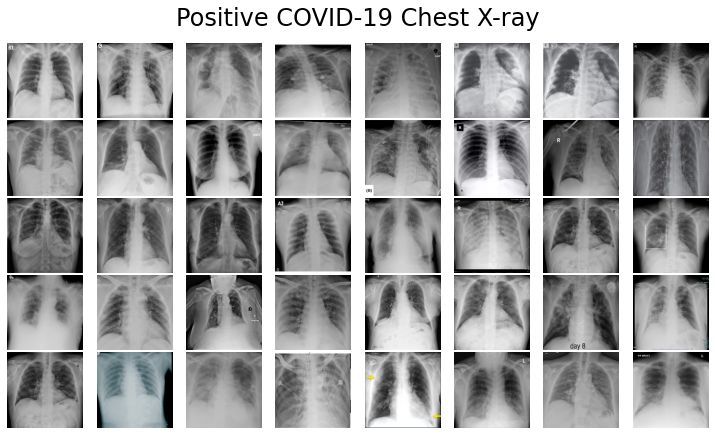

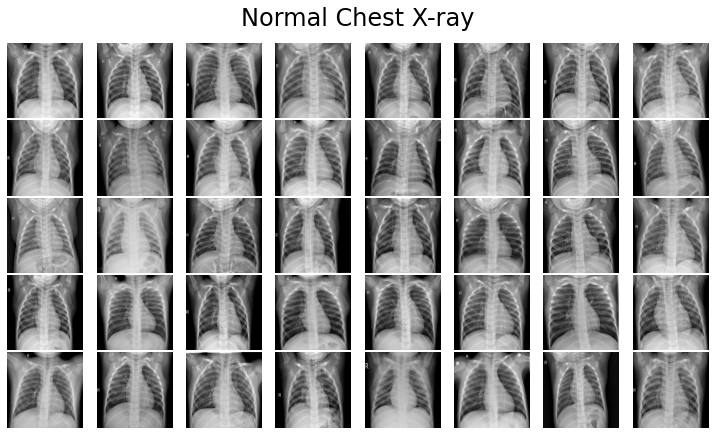

In [10]:
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(normal_images, 'Normal Chest X-ray')

In [11]:
#normalize to (0,1)
covid_images=np.array(covid_images)/255.0
normal_images=np.array(normal_images)/255.0
# pneumonia_images=np.array(pneumonia_images)/255.0

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

#split to train,test
covid_x_train,covid_x_test,covid_y_train,covid_y_test=train_test_split(covid_images,covid_labels,test_size=.2)
normal_x_train,normal_x_test,normal_y_train,normal_y_test=train_test_split(normal_images,normal_labels,test_size=.2)
# pneumonia_x_train,pneumonia_x_test,pneumonia_y_train,pneumonia_y_test=train_test_split(pneumonia_images,pneumonia_labels,test_size=.2)

# X_train=np.concatenate((pneumonia_x_train,normal_x_train,covid_x_train),axis=0)
# X_test=np.concatenate((pneumonia_x_test,normal_x_test,covid_x_test),axis=0)
# Y_train=np.concatenate((pneumonia_y_train,normal_y_train,covid_y_train),axis=0)
# Y_test=np.concatenate((pneumonia_y_test,normal_y_test,covid_y_test),axis=0)


X_train=np.concatenate((normal_x_train,covid_x_train),axis=0)
X_test=np.concatenate((normal_x_test,covid_x_test),axis=0)
Y_train=np.concatenate((normal_y_train,covid_y_train),axis=0)
Y_test=np.concatenate((normal_y_test,covid_y_test),axis=0)

In [13]:
Y_train=LabelBinarizer().fit_transform(Y_train)
Y_train=to_categorical(Y_train)

Y_test=LabelBinarizer().fit_transform(Y_test)
Y_test=to_categorical(Y_test)

In [16]:
vgg16=VGG16(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

outputs=vgg16.output
outputs=AveragePooling2D(pool_size=(4,4))(outputs)
outputs=Dropout(.5)(outputs)
outputs=Flatten(name='flattern')(outputs)
outputs=Dropout(.5)(outputs)
outputs=Dense(64,activation='relu')(outputs)
outputs=Dropout(.5)(outputs)
outputs=Dense(2,activation='softmax')(outputs)

model=Model(inputs=vgg16.input,outputs=outputs)

for layer in vgg16.layers:
  layer.trainable=False

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

train_aug=ImageDataGenerator(
    rotation_range=20,
    width_shift_range=.2,
    height_shift_range=.2,
    horizontal_flip=True
)

In [17]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose=1, monitor='loss',save_best_only=True, mode='auto')

In [18]:
history=model.fit(train_aug.flow(X_train,Y_train,batch_size=32),
                  validation_data=(X_test,Y_test),
                  validation_steps=len(X_test)/32,
                  steps_per_epoch=len(X_train)/32,
                  callbacks=[checkpoint],
                  epochs=70
)

Epoch 1/70
29/28 [==============================] - ETA: 0s - loss: 0.9152 - accuracy: 0.5524
Epoch 00001: loss improved from inf to 0.91516, saving model to model.h5
29/28 [==============================] - 10s 344ms/step - loss: 0.9152 - accuracy: 0.5524 - val_loss: 0.5369 - val_accuracy: 0.9174
Epoch 2/70
29/28 [==============================] - ETA: 0s - loss: 0.7398 - accuracy: 0.6190
Epoch 00002: loss improved from 0.91516 to 0.73981, saving model to model.h5
29/28 [==============================] - 9s 326ms/step - loss: 0.7398 - accuracy: 0.6190 - val_loss: 0.5171 - val_accuracy: 0.9087
Epoch 3/70
29/28 [==============================] - ETA: 0s - loss: 0.5908 - accuracy: 0.6932
Epoch 00003: loss improved from 0.73981 to 0.59078, saving model to model.h5
29/28 [==============================] - 9s 323ms/step - loss: 0.5908 - accuracy: 0.6932 - val_loss: 0.4748 - val_accuracy: 0.9000
Epoch 4/70
29/28 [==============================] - ETA: 0s - loss: 0.5806 - accuracy: 0.7151
Epo

In [19]:
#load saved model
model=load_model('model.h5')

In [20]:
y_pred=model.predict(X_test,batch_size=32)

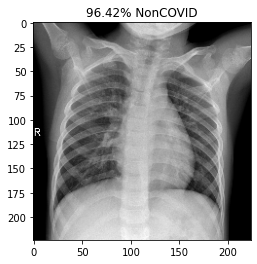

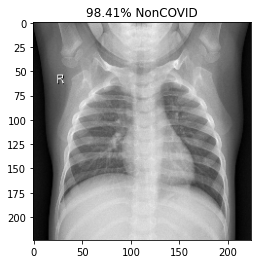

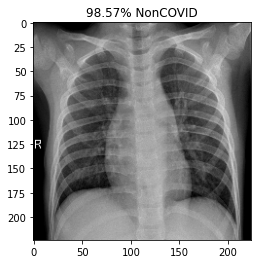

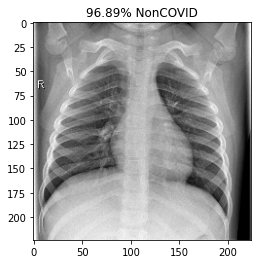

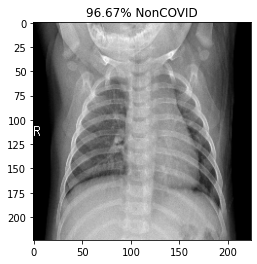

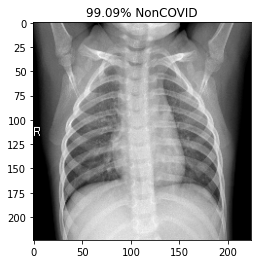

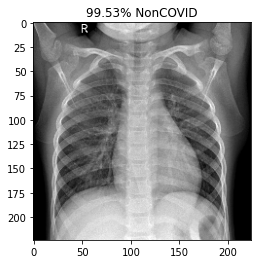

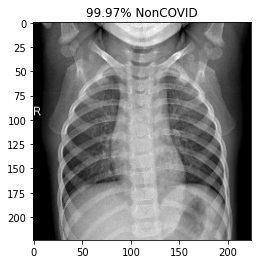

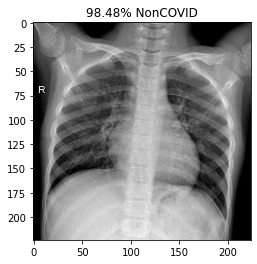

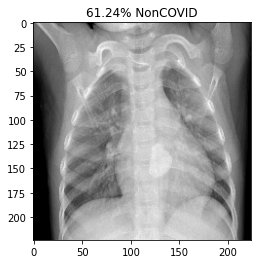

In [21]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% NonCOVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% COVID')
  plt.imshow(X_test[index])
  plt.show()

In [22]:
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(Y_test, axis=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Confusion Matrix without Normalization


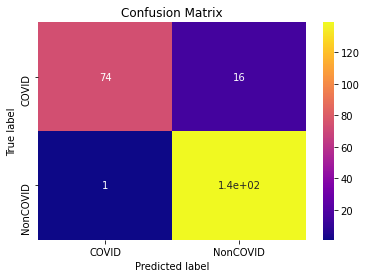

Confusion Matrix with Normalized Values


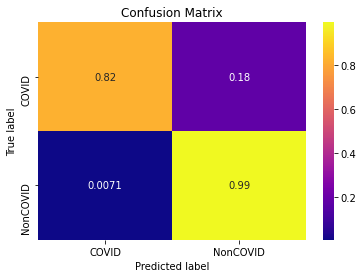

In [23]:
import seaborn as sns
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

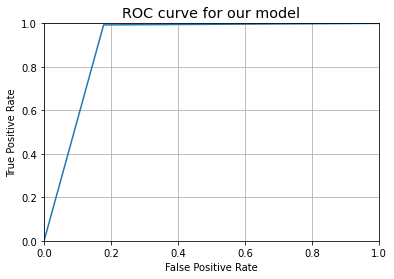

In [24]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.99      0.82      0.90        90
           1       0.90      0.99      0.94       140

    accuracy                           0.93       230
   macro avg       0.94      0.91      0.92       230
weighted avg       0.93      0.93      0.92       230



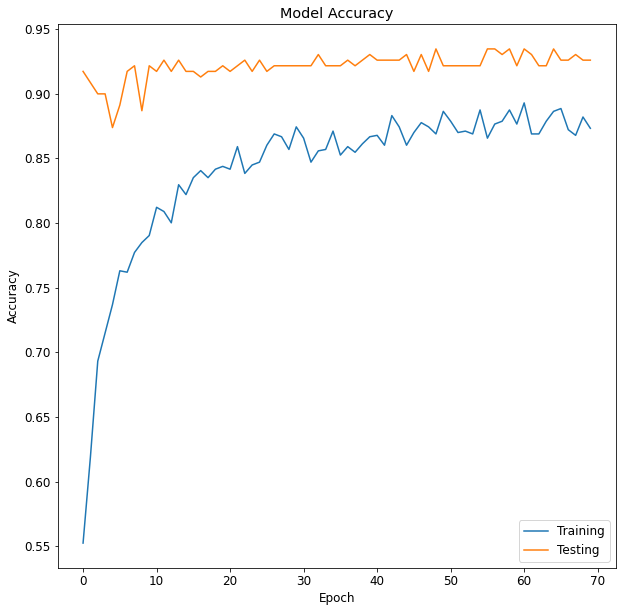

In [26]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.show()

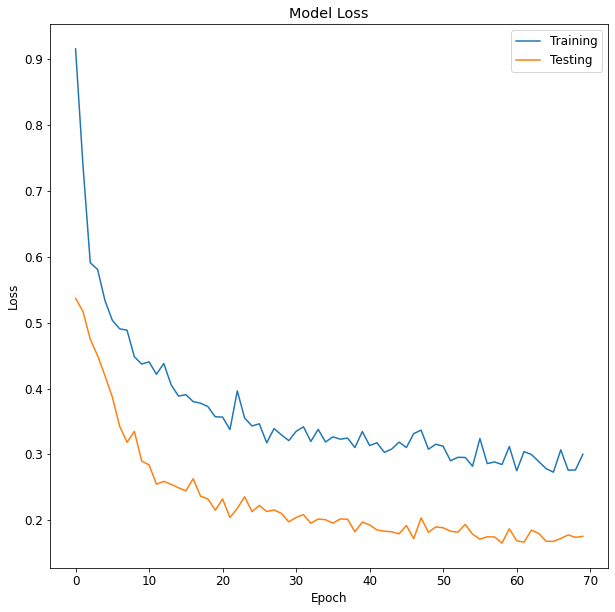

In [27]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_loss.png')
plt.show()

In [28]:
shutil.copy2('/content/model.h5','/content/drive/My Drive/Untitled folder')

'/content/drive/My Drive/Untitled folder/model.h5'